In [24]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np
from sklearn.utils import shuffle
import torch.nn as nn
from torchvision.models import resnet18
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy, AveragePrecision
import os
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATALOADERS AND DATASETS

Dataloaders for Noise Regularization model

In [27]:
img_path = '/content/drive/MyDrive/DLProject/Images'
model_path = '/content/drive/MyDrive/DLProject/Models'

In [28]:
class NRLoader:
    def __init__(self, path, download=True):
        """
        Give path for where to download the data
        """

        self.path = path
        self.download = download
        self.transform_original = transforms.Compose([transforms.ToTensor(),
                                                      transforms.Normalize((0.5,), (0.5,))])

        self.trainset = datasets.FashionMNIST(self.path,
                                              download=self.download,
                                              train=True,
                                              transform=self.transform_original)
        self.noisyset = datasets.FashionMNIST(self.path,
                                              download=self.download,
                                              train=True,
                                              transform=self.transform_original)
        self.testset = datasets.FashionMNIST(self.path,
                                             download=self.download,
                                             train=False,
                                             transform=self.transform_original)

    def noisy_clean_split(self, clean_size):
        noisy_ind, clean_ind, _, _ = train_test_split(
            range(len(self.trainset)),
            self.trainset.targets,
            stratify=self.trainset.targets,
            test_size=clean_size)

        return noisy_ind, clean_ind

    def shuffle_noisy_targets(self):
        ind = torch.randperm(len(self.noisyset))
        self.noisyset.targets = self.noisyset.targets[ind]

    def noisy_set(self, c):
        """
        Returns original data
        """
        noisy_ind, clean_ind = self.noisy_clean_split(clean_size = c)
        clean_data = Subset(self.trainset, clean_ind)
        self.shuffle_noisy_targets()
        noisy_data = Subset(self.noisyset, noisy_ind)
        test_data = self.testset

        return noisy_data, clean_data, test_data

    def noisy_loader(self, val=True, batch_size=64, c = 0.1):
        """
        Returns original data loader
        """
        noisy_data, clean_data, test_data = self.noisy_set(c)

        noisy_loader = torch.utils.data.DataLoader(noisy_data, batch_size=int((1-c)*batch_size),
                                                   shuffle=True, num_workers=0)
        clean_loader = torch.utils.data.DataLoader(clean_data, batch_size=int(c*batch_size),
                                                 shuffle=True, num_workers=0)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                                  shuffle=True, num_workers=0)
        return noisy_loader, clean_loader, test_loader


In [31]:
g = NRLoader('./data/')

In [32]:
noisy_loader, clean_loader, test_loader = g.noisy_loader(batch_size=3000)
class_lab = {0	: 'T-shirt/top',
1	:'Trouser',
2	:'Pullover',
3	:'Dress',
4	:'Coat',
5	:'Sandal',
6	:'Shirt',
7	:'Sneaker',
8	:'Bag',
9	:'Ankle boot'}

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualise(loader):
  dataiter = iter(loader)
  print(dataiter)
  images, labels = dataiter.next()


  fig = plt.figure(figsize=(15,5))
  for idx in np.arange(20):
    # xticks=[], yticks=[] is empty to print the images without any ticks around them
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # .item() gets the value contained in a Tensor
    ax.set_title(class_lab[labels[idx].item()])
    fig.tight_layout()

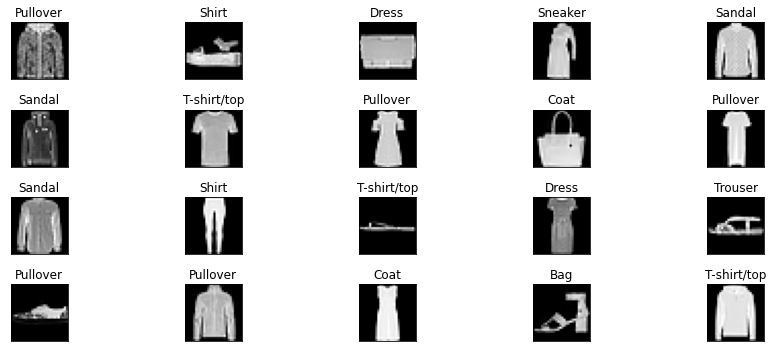

In [34]:
visualise(noisy_loader)

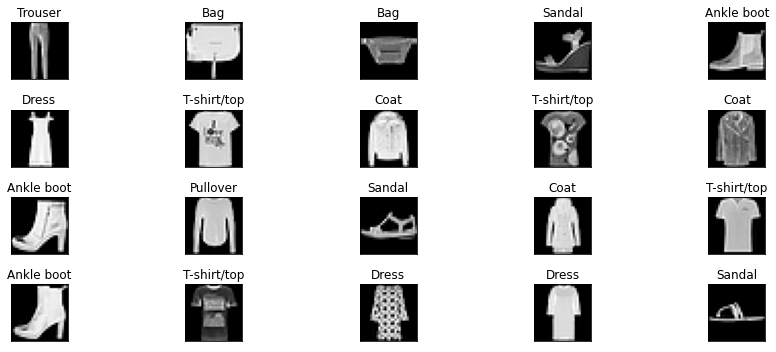

In [35]:
visualise(clean_loader)

Iter = 0


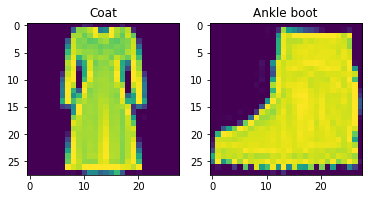

In [36]:
noisy_iter = iter(noisy_loader)
for step, (X,y) in enumerate(clean_loader):
  print("Iter = {}".format(step))
  X_noisy, y_noisy = noisy_iter.next()
  fig, axs = plt.subplots(1, 2)
  idx = X_noisy.shape[0]-1
  idx2 = X.shape[0]-1
  axs[0].imshow(np.squeeze(X_noisy[idx]))
  axs[0].set_title(class_lab[y_noisy[idx].item()])
  axs[1].imshow(np.squeeze(X[idx2]))
  axs[1].set_title(class_lab[y[idx2].item()])
  break


##MODEL ARCHITECTURE AND TRAINING

In [37]:
## WSGAN Classifier

class _ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=2)
        self.spectral_conv = nn.utils.parametrizations.spectral_norm(conv)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Interior block of a convolutional block
        :param x: Images
            Shape: `(bsz, in_channels, H, W)
        :return:
        """
        x = self.spectral_conv(x)
        x = self.leaky_relu(x)
        return x


class ConvolutionBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        hidden_channels = output_channels // 2
        self.conv_block1 = _ConvolutionalBlock(input_channels, hidden_channels)
        self.conv_block2 = _ConvolutionalBlock(hidden_channels, output_channels)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Convolutional block
        :param X: images
            Shape: `(bsz, input_channes, H, W)
        :return: torch.Tensor
            Shape: `(bsz, output_channels, H - 2, W - 2)'
        """
        block1 = self.conv_block1(X)
        block2 = self.conv_block2(block1)
        return block2 + self.avg_pool(torch.cat([block1, block1], dim=1))


class SpatialAttention(nn.Module):
    def __init__(self, in_chans):
        super().__init__()
        self.q = nn.Conv2d(in_chans, in_chans, kernel_size=1)
        self.k = nn.Conv2d(in_chans, in_chans, kernel_size=1)
        self.v = nn.Conv2d(in_chans, in_chans, kernel_size=1)
        self.soft_max = nn.Softmax(dim=2)
        self.out = nn.Linear(in_chans, in_chans)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """

        :param x:
        :return:
        """
        bsz, in_chans, h, w = x.shape
        q = self.q(x).reshape(bsz, in_chans, h * w)
        k = self.k(x).reshape(bsz, in_chans, h * w)
        v = self.v(x).reshape(bsz, in_chans, h * w)
        qk = torch.matmul(q.permute(0, 2, 1), k) / (h * w) ** .5  # (bsz, h * w, h * w)
        attn = torch.matmul(self.soft_max(qk), v.permute(0, 2, 1))  # (bsz, h * w, in_chans)
        return self.out(attn).permute(0, 2, 1).reshape(bsz, in_chans, h, w)


class PixelAttention(nn.Module):
    def __init__(self, in_chans):
        super().__init__()
        self.q = nn.Conv2d(in_chans, in_chans, kernel_size=1)
        self.k = nn.Conv2d(in_chans, in_chans, kernel_size=1)
        self.v = nn.Conv2d(in_chans, in_chans, kernel_size=1)
        self.soft_max = nn.Softmax(dim=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """

        :param x:
        :return:
        """
        bsz, in_chans, h, w = x.shape
        q = self.q(x).reshape(bsz, in_chans, h * w)
        k = self.k(x).reshape(bsz, in_chans, h * w)
        v = self.v(x).reshape(bsz, in_chans, h * w)
        qk = torch.matmul(q, k.permute(0, 2, 1)) / (h * w) ** .5  # (bsz, h * w, h * w)
        attn = torch.matmul(self.soft_max(qk), v)  # (bsz, h * w, in_chans)
        return attn.permute(0, 2, 1).reshape(bsz, in_chans, h, w)


class ClassifierBlock(nn.Module):
    def __init__(self, in_chans, out_chans):
        super().__init__()
        hidden_chans = out_chans // 2
        conv_block1 = ConvolutionBlock(in_chans, hidden_chans)
        conv_block2 = ConvolutionBlock(hidden_chans, out_chans)
        self.block = nn.Sequential(
            conv_block1,
            conv_block2
        )
        self.spatial_attn = SpatialAttention(out_chans)
        self.pixel_attn = PixelAttention(out_chans)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """

        :param x:
        :return:
        """
        out = self.block(x)
        pix = self.pixel_attn(out)
        spat = self.spatial_attn(out)

        return pix + spat


class Classifier(nn.Module):

    def __init__(self, in_chans, out_chans, spec_chans, depth=2):
        super().__init__()
        self.classifier_block1 = ClassifierBlock(in_chans, out_chans)
        if depth == 2:
            self.classifier_block2 = ClassifierBlock(spec_chans, spec_chans)
        self.depth = depth
        conv_out = nn.Conv2d(out_chans, spec_chans, kernel_size=2)
        self.spect_conv = nn.utils.parametrizations.spectral_norm(conv_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.classifier_block1(x)
        if self.depth == 2:
            out = self.classifier_block2(out)
        return self.spect_conv(out)


class WSGANClassifier(nn.Module):
    def __init__(self, in_chans, out_chans, spec_chans, resnet_path: str = 'model_dump/resnet_conv.pt', n_classes=10):
        super().__init__()
        self.resnet_convert = nn.Linear(1, 3)
        self.resnet_conv = torch.load(resnet_path)
        self.resnet_fc = nn.Linear(512, n_classes + 1)
        self.local_class = Classifier(in_chans, out_chans, spec_chans, depth=1)
        self.global_class = Classifier(in_chans, out_chans, spec_chans)
        self.glob_dense = nn.Linear(spec_chans, n_classes + 1)
        self.loc_dense = nn.Linear(spec_chans, n_classes + 1)
        self.sigmoid_ = nn.Sigmoid()
    def forward(self, x: torch.Tensor):
        res_in = self.resnet_convert(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        res_out = self.resnet_conv(res_in)
        res_out = self.resnet_fc(res_out.flatten(1))
        loc_out = self.local_class(x)
        loc_avg = F.avg_pool2d(loc_out, loc_out.shape[-1])
        loc_max = F.max_pool2d(loc_out, loc_out.shape[-1])
        loc_out = self.loc_dense((loc_avg + loc_max).flatten(1))
        glob_out = self.global_class(x)
        glob_avg = F.avg_pool2d(glob_out, glob_out.shape[-1])
        glob_max = F.max_pool2d(glob_out, glob_out.shape[-1])
        glob_out = self.glob_dense((glob_max + glob_avg).flatten(1))
        out = loc_out + glob_out + res_out

        return out
    def sigmoid(self, x):
        x[:, :-1] = F.softmax(x[:, :-1], dim=-1)
        x[:, -1] = self.sigmoid_(x[:, -1])
        return x


In [38]:
## Generator Model 

class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, dilation, out_padding=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=(4, 4),
                stride=stride,
                dilation=dilation,
                output_padding=out_padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.block(x)
        return x


class Generator(nn.Module):
    def __init__(self, depth, out_channels, noise_size):
        super(Generator, self).__init__()
        self.gen = nn.Sequential()
        strides = [2, 2, 2, 1, 1]
        dilation = [1, 4, 2, 1, 1]
        out_padding = [0, 0, 0, 0, 0]
        depth = len(strides)
        for i in range(depth - 1):
            self.gen.append(
                DeconvBlock(
                    noise_size // 2 ** i,
                    noise_size // 2 ** (i + 1),
                    stride=strides[i],
                    dilation=dilation[i],
                    out_padding=out_padding[i]
                )
            )
        self.gen.append(DeconvBlock(noise_size // 2 ** (i + 1), noise_size // 2 ** (i + 2), stride=strides[-1], dilation=dilation[-1], out_padding=out_padding[-1]))
        self.noise_size = noise_size
        self.label_proj = nn.Linear(1, noise_size)
        self.gen.append(nn.Conv2d(noise_size // 2 ** (i + 2), out_channels, kernel_size=3, stride=2))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor, fake_labels: torch.Tensor) -> torch.Tensor:
        fake_labels = self.label_proj(fake_labels.unsqueeze(1).float() / 9)
        x = x + fake_labels
        x = x.reshape(-1, self.noise_size, 1, 1)
        x = self.gen(x)

        x = self.sigmoid(x)
        x = F.pad(x, (2, 2, 2, 2))
        return x


## Original NR model

In [39]:
'''model architecture
1. ResNet-18 pretrained with imagenet
2. Clean Net - linear, activation, linear
3. Residual Net - linear, activation, linear
'''
num_labels = 10

class ResNet(nn.Module):
  def __init__(self):
        super(ResNet, self).__init__()
        resnet = resnet18(weights='DEFAULT')
        self.resnet_conv = nn.Sequential(*(list(resnet.children())[:-1]))

  def forward(self, x):

      featureNet = self.resnet_conv(x.expand(-1, 3, -1, -1).to(device)) #bsz x 512 x 1 x 1 
      return featureNet.squeeze()

class CleanNet(nn.Module):
    def __init__(self):
        super(CleanNet, self).__init__()
        self.linear1 = nn.Linear(512, 384)
        self.linear4 = nn.Linear(384, num_labels)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return self.linear4(x)

class ResidualNet(nn.Module):
    def __init__(self):
        super(ResidualNet, self).__init__()
        self.linear1 = nn.Linear(512, 384)
        self.linear2 = nn.Linear(384, num_labels) 

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return self.linear2(x)

class NoisyModel(nn.Module):

  def __init__(self):
    super(NoisyModel, self).__init__()
    self.ResNet = ResNet()
    self.ResidualNet = ResidualNet()
    self.CleanNet = CleanNet()

  def forward(self, X_noisy: torch.Tensor, X_clean: torch.Tensor, y_noisy: torch.Tensor):

        X_noisy = self.ResNet(X_noisy)
        X_clean = self.ResNet(X_clean)
      
        r = self.ResidualNet(X_noisy)
        c = self.CleanNet(X_noisy)
        h = F.softmax(r+c, dim = 1)

        c = self.CleanNet(X_clean)
        g = F.softmax(c, dim = 1)

        return h.float(),g.float()
      


## GAN classifier model

This model uses the GAN as the residual network

In [40]:
class GANClassifier(nn.Module):
    def __init__(self):
        super(GANClassifier, self).__init__()
        noise_features = 64
        self.linear1 = nn.Linear(512, 216)
        self.linear2 = nn.Linear(216, noise_features) 
        self.classifier = WSGANClassifier(1, 64, 64, f'{model_path}/resnet.pt')
        self.generator = Generator(9, 1, noise_features)

        self.generator.load_state_dict(torch.load(f'{model_path}/generator2.pt'))

    def forward(self, x, y):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        im = self.generator(x, y)
        out = self.classifier(im)
        return out[:,:10]

class GANNoisyModel(nn.Module):

  def __init__(self):
    super(GANNoisyModel, self).__init__()
    self.ResNet = ResNet()
    self.GANClassifier = GANClassifier()
    self.CleanNet = CleanNet()

  def forward(self, X_noisy: torch.Tensor, X_clean: torch.Tensor, y_noisy: torch.Tensor):

        X_noisy = self.ResNet(X_noisy)
        X_clean = self.ResNet(X_clean)
      
        r = self.GANClassifier(X_noisy, y_noisy)
        c = self.CleanNet(X_noisy)
        h = F.softmax(r+c, dim = 1)

        c = self.CleanNet(X_clean)
        g = F.softmax(c, dim = 1)

        return h.float(),g.float()

In [77]:
#Training function called by trainer

def train(classfier_model, opt):
  classfier_model.train()
  training_loss = 0
  min_loss = 10e10
  noisy_iter = iter(noisy_loader)
  for batch_ind, (X_clean,y_clean) in enumerate(clean_loader):
      
      try:
          X_noisy, y_noisy = next(noisy_iter)
      except StopIteration:
          noisy_iter = iter(noisy_loader)
          X_noisy, y_noisy = next(noisy_iter)

      X_noisy = X_noisy.to(device)
      X_clean = X_clean.to(device)
      y_clean = y_clean.to(device)
      y_noisy = y_noisy.to(device)
      
      opt.zero_grad()
      h,g, = classfier_model(X_noisy, X_clean, y_noisy)
      y_clean = F.one_hot(y_clean, num_classes=10)
      y_noisy = F.one_hot(y_noisy, num_classes=10) 
      loss = (alpha * criterion(y_clean.float(), g)) + criterion(y_noisy.float(), h)
      loss.backward()
      opt.step()
      training_loss += loss.item() 
      
  if (training_loss/(batch_ind+1)) < min_loss:
      torch.save(classfier_model.state_dict(), f"{model_path}/ckpt_model.pth")
      min_loss = training_loss/(batch_ind+1)

  return training_loss/(batch_ind+1)


def test(classfier_model):
  classfier_model.eval()
  test_loss = 0

  with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
      x, y = x.to(device), y.to(device)
      x = classfier_model.ResNet(x)
      pred = F.softmax(classfier_model.CleanNet(x), dim = 1)
      y_clean = F.one_hot(y, num_classes=10)
      l = criterion(y_clean.float(), pred)
      test_loss += l.cpu().detach()
  return test_loss/(i+1)

## Function for loss

The following plots the train and test loss obtained by our model over the epochs. 

In [44]:
def plot_losses(train_loss, test_loss, filename):
  plt.plot(list(range(n_epochs)), train_losses, label='Train loss')
  plt.plot(list(range(n_epochs)), test_losses, label='Test loss')
  plt.legend()
  plt.savefig(f"{img_path}/{filename}")
  plt.show()

## Functions for metrics

The following consists of two functions:
1. Get Accuracy: Compares the output of the true and predicted labels and computes the accuracy.
2. Get Avg Precision: This is for cases where an image can have multiple labels.

In [45]:
#create a new dataset to compute accuracy

metric_set = datasets.FashionMNIST("../../data",
                                download=True,
                                train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                      transforms.Normalize((0.5,), (0.5,))]))
metric_loader = torch.utils.data.DataLoader(metric_set, batch_size=10000,num_workers=0)

In [46]:
def get_accuracy(model):
  model.eval()
  with torch.no_grad():
    for i, (x, y) in enumerate(metric_loader):
      x, y = x.to(device), y.to(device)
      x = model.ResNet(x)
      pred = F.softmax(model.CleanNet(x), dim = 1)
      pred_label = torch.argmax(pred,dim=1)
      acc = torch.sum(y == pred_label)/10000
  return acc.cpu().numpy()

def get_average_precision(model):
  model.eval()
  map = AveragePrecision(task="multiclass", num_classes=10, average='weighted').to(device)
  apc = AveragePrecision(task="multiclass", num_classes=10, average='macro').to(device)
  map_, apc_ = 0, 0
  with torch.no_grad():
    for i, (x, y) in enumerate(metric_loader):
      x, y = x.to(device), y.to(device)
      x = model.ResNet(x)
      pred = F.softmax(model.CleanNet(x), dim = 1)
      # y_clean = F.one_hot(y, num_classes=10)
      map_ = map(pred, y)
      apc_ = apc(pred, y)
  return map_.cpu().numpy(), apc_.cpu().numpy()

In [47]:
#MODEL HYPERPARAMETERS

alpha = 1
n_epochs = 20
criterion  = nn.CrossEntropyLoss()
lr= 1e-4
weight_decay=1e-4
batch_size = 3000

## Trainer for NR

This functions trains the NR model (GANNoisyModel) whose architecture was defined earlier, with the default backbone CNN being a resnet, a residual network and a clean network. 

We supply a different combination of clean:noisy labels as described by c_pcts to the model, which then trains each of the models for ten epochs. We store the accuracy of the model over a test set.  

In [48]:
c_pcts = [0.05,0.1,0.2,0.5,0.7]
n_epochs = 10
acc_df = pd.DataFrame(columns=['Clean_pct', 'Accuracy'])
ap_df = pd.DataFrame(columns=['Clean_pct', 'mAP', "APc"])
for c in c_pcts:
  print("Pct of clean labels = {}".format(c))
  g = NRLoader('./data/')
  noisy_loader, clean_loader, test_loader = g.noisy_loader(batch_size=3000, c = c)
  print(len(noisy_loader), len(clean_loader), len(test_loader))

  model = NoisyModel().to(device)
  opt = optim.Adam(model.parameters(), lr= lr, weight_decay=weight_decay)

  train_losses = []
  test_losses = []
  for e in range(n_epochs):
    train_loss = train(model, opt)
    train_losses.append(train_loss)
    test_loss = test(model)
    test_losses.append(test_loss)
    print("Epoch : {} \t Train/Test loss : {}/{}".format(e, train_loss, test_loss))
  plot_losses(train_losses, test_losses, f"NR_losses_c{c}.png")
  acc_df.loc[len(acc_df)] = [c, get_accuracy(model)]
  print(get_accuracy(model))
  map_, apc_ = get_average_precision(model)
  ap_df.loc[len(ap_df)] = [c, map_, apc_]
  torch.save(model.state_dict(),f'{model_path}/NR_{c}.pt' )

In [75]:
#loading the noise regularizer models and computing the accuracy 

acc_df = pd.DataFrame(columns=['Clean_pct', 'Accuracy'])
for c in c_pcts:
  nm = NoisyModel().to(device)
  nm.load_state_dict(torch.load(f'{model_path}/NR_{c}.pt'))
  acc_df.loc[len(acc_df)] = [c, get_accuracy(nm)]

In [76]:
#Printing the accuracy for each model trained with a varying clean:noisy ratio

acc_df

,Clean_pct,Accuracy
0,0.05,0.8373
1,0.10,0.8612
2,0.20,0.8714
3,0.50,0.88839996
4,0.70,0.88989997


## Trainer for NR with WSGAN:

This functions trains the NR-WSGAN model (GANNoisyModel) whose architecture was defined earlier, with the GAN model performing the function of a residual net.

We supply a different combination of clean:noisy labels as described by c_pcts to the model, which then trains each of the models for ten epochs. We store the accuracy of the model over a test set.  

Pct of clean labels = 0.05
Epoch : 0 	 Train/Test loss : 4.118603309392929/1.8054747581481934
Epoch : 1 	 Train/Test loss : 3.3019907426834108/1.7495733499526978
Epoch : 2 	 Train/Test loss : 3.2073560309410096/1.7265337705612183
Epoch : 3 	 Train/Test loss : 3.1804070830345155/1.7112467288970947
Epoch : 4 	 Train/Test loss : 3.16847793340683/1.7489217519760132
Epoch : 5 	 Train/Test loss : 3.1888473665714265/1.7939581871032715
Epoch : 6 	 Train/Test loss : 3.156786085367203/1.7316744327545166
Epoch : 7 	 Train/Test loss : 3.1524826323986055/1.694145679473877
Epoch : 8 	 Train/Test loss : 3.1462181329727175/1.7414079904556274
Epoch : 9 	 Train/Test loss : 3.1303567481040955/1.7398592233657837


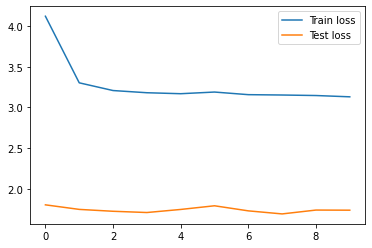

Pct of clean labels = 0.1
Epoch : 0 	 Train/Test loss : 3.798170291185379/1.709524393081665
Epoch : 1 	 Train/Test loss : 3.200134174823761/1.6731541156768799
Epoch : 2 	 Train/Test loss : 3.140214445590973/1.672224760055542
Epoch : 3 	 Train/Test loss : 3.1289684796333312/1.6698540449142456
Epoch : 4 	 Train/Test loss : 3.136341952085495/1.7115501165390015
Epoch : 5 	 Train/Test loss : 3.1302865076065065/1.6665164232254028
Epoch : 6 	 Train/Test loss : 3.114376126527786/1.6897540092468262
Epoch : 7 	 Train/Test loss : 3.117833876609802/1.668479561805725
Epoch : 8 	 Train/Test loss : 3.10821643948555/1.6954021453857422
Epoch : 9 	 Train/Test loss : 3.1057203352451324/1.681412696838379


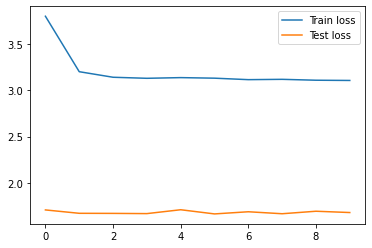

Pct of clean labels = 0.2
Epoch : 0 	 Train/Test loss : 4.198339161872863/1.6919260025024414
Epoch : 1 	 Train/Test loss : 3.584179925918579/1.6536715030670166
Epoch : 2 	 Train/Test loss : 3.275463516712189/1.6506657600402832
Epoch : 3 	 Train/Test loss : 3.1587902295589445/1.6578441858291626
Epoch : 4 	 Train/Test loss : 3.13647084236145/1.634411334991455
Epoch : 5 	 Train/Test loss : 3.133051673173904/1.6321401596069336
Epoch : 6 	 Train/Test loss : 3.1192450022697447/1.63460111618042
Epoch : 7 	 Train/Test loss : 3.0888636612892153/1.62862229347229
Epoch : 8 	 Train/Test loss : 3.091685599088669/1.636793851852417
Epoch : 9 	 Train/Test loss : 3.083844518661499/1.6323586702346802


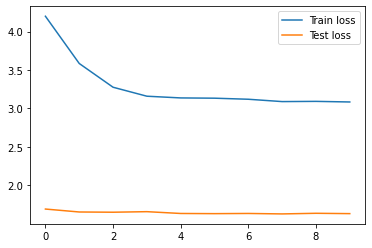

Pct of clean labels = 0.5
Epoch : 0 	 Train/Test loss : 4.1197559356689455/1.6197874546051025
Epoch : 1 	 Train/Test loss : 3.9456785988807677/1.6011351346969604
Epoch : 2 	 Train/Test loss : 3.7598127937316894/1.5947462320327759
Epoch : 3 	 Train/Test loss : 3.5349634611606597/1.5860731601715088
Epoch : 4 	 Train/Test loss : 3.284076852798462/1.5838745832443237
Epoch : 5 	 Train/Test loss : 3.1225632393360137/1.574695348739624
Epoch : 6 	 Train/Test loss : 3.058422749042511/1.5711774826049805
Epoch : 7 	 Train/Test loss : 3.0532472777366637/1.5793116092681885
Epoch : 8 	 Train/Test loss : 3.027960343360901/1.567712426185608
Epoch : 9 	 Train/Test loss : 3.0100896561145785/1.5636953115463257


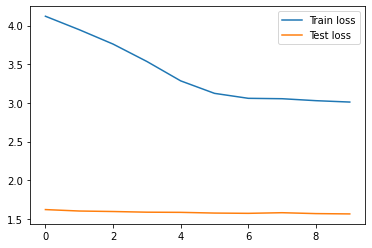

Pct of clean labels = 0.7
Epoch : 0 	 Train/Test loss : 4.039971867799759/1.6771317720413208
Epoch : 1 	 Train/Test loss : 3.595119285583496/1.6297351121902466
Epoch : 2 	 Train/Test loss : 3.441328605413437/1.6032278537750244
Epoch : 3 	 Train/Test loss : 3.2622171437740324/1.5837327241897583
Epoch : 4 	 Train/Test loss : 3.085882205963135/1.5793417692184448
Epoch : 5 	 Train/Test loss : 3.0251838934421538/1.573169231414795
Epoch : 6 	 Train/Test loss : 3.0387390339374543/1.5638912916183472
Epoch : 7 	 Train/Test loss : 3.020001630783081/1.5701475143432617
Epoch : 8 	 Train/Test loss : 3.0033604848384856/1.5633459091186523
Epoch : 9 	 Train/Test loss : 3.009300527572632/1.5564128160476685


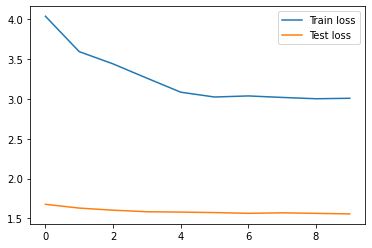

In [55]:
## Model with WSGAN in place of residual net

import tqdm
c_pcts = [0.05,0.1,0.2,0.5,0.7]
n_epochs = 10
acc_df = pd.DataFrame(columns=['Clean_pct', 'Accuracy'])
ap_df = pd.DataFrame(columns=['Clean_pct', 'mAP', "APc"])
for c in c_pcts:
  print("Pct of clean labels = {}".format(c))
  g = NRLoader('./data/')
  noisy_loader, clean_loader, test_loader = g.noisy_loader(batch_size=300, c = c)


  model = GANNoisyModel().to(device)
  opt = optim.Adam(model.parameters(), lr= lr, weight_decay=weight_decay)

  train_losses = []
  test_losses = []
  for e in range(n_epochs):
    train_loss = train(model, opt)
    train_losses.append(train_loss)
    test_loss = test(model)
    test_losses.append(test_loss)
    print("Epoch : {} \t Train/Test loss : {}/{}".format(e, train_loss, test_loss))
  plot_losses(train_losses, test_losses, f"losses_c{c}.png")
  acc_df.loc[len(acc_df)] = [c, get_accuracy(model)]
  map_, apc_ = get_average_precision(model)
  ap_df.loc[len(ap_df)] = [c, map_, apc_]
  torch.save(model.state_dict(),f'{model_path}/NR_WSGAN_{c}.pt' )

In [58]:
#Printing the accuracy for each model trained with a varying clean:noisy ratio

acc_df

,Clean_pct,Accuracy
0,0.05,0.778
1,0.10,0.8107
2,0.20,0.8293
3,0.50,0.8986
4,0.70,0.9068


## Printing Images and their top 3 predictions



In [60]:
#creating a dataset and loader for 3 images

three_set = datasets.FashionMNIST("../../data",
                                download=True,
                                train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                      transforms.Normalize((0.5,), (0.5,))]))
three_loader = torch.utils.data.DataLoader(three_set, batch_size=3,
                                                  shuffle=True, num_workers=0)

In [71]:
#getting the top 3 predicted labels for an image

three_ = iter(three_loader)
im, lab = three_.next()
x_im = model.ResNet(im)
pred = F.softmax(model.CleanNet(x_im), dim = 1)
im, lab = im.detach().cpu().numpy(), lab.detach().cpu().numpy()
val, ind = torch.topk(pred,3,dim=1)

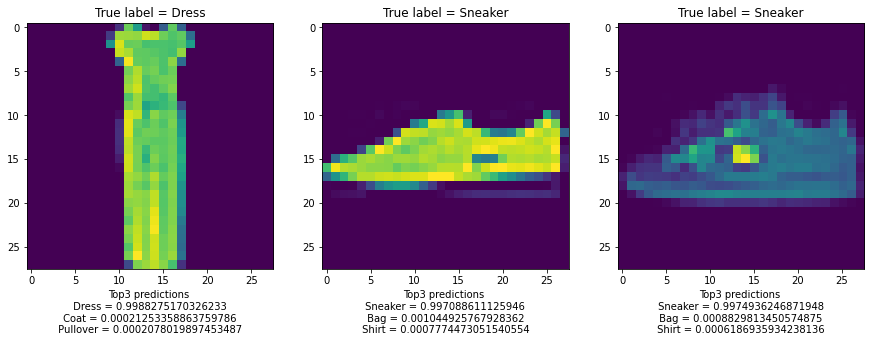

In [74]:
#plotting the images

fig, axs = plt.subplots(1, 3,figsize=(15, 15))
for i in range(3):
  axs[i].imshow(np.squeeze(im[i]))
  axs[i].set_title(f"True label = {class_lab[lab[i].item()]}")
  axs[i].set(xlabel=f"Top3 predictions \n {class_lab[ind[i,0].item()]} = {val[i,0].item()} \n {class_lab[ind[i,1].item()]} = {val[i,1].item()} \n {class_lab[ind[i,2].item()]} = {val[i,2].item()} ")

filename = 'NR_WSGAN_Top3.png'
plt.savefig(f"{img_path}/{filename}")